In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
 pip install l5kit

     |████████████████████████████████| 92kB 3.9MB/s 
     |████████████████████████████████| 133kB 9.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 42.9MB 123kB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 5.8MB 31.4MB/s 
  Created wheel for pymap3d: filename=pymap3d-2.4.3-cp36-none-any.whl size=33551 sha256=44a44f64c65cc1a346b30c86d599cb9723b6a79d1ea4ce756dce5f4b8b832cd4
  Stored in directory: /root/.cache/pip/wheels/be/e2/40/c642184272827b886ddb12661008199fe1460d4b05ddfc2670
Successfully built pymap3d
  Created wheel for transforms3d: filename=transforms3d-0.3.1-cp36-none-any.whl size=59374 sha256=c5bb156be28a925812e14476b1ca939e0b89ce9079de325eec69277475a57d4a
  Stored in directory: /root/.cache/pip/wheels/3d/3c/84/28d36677f3c760c048bd02b5a547ea0c4027770cc9cdb9af1e
  Created wheel for ptable: filename=PTabl

In [2]:
import os
import toml
from tqdm import tqdm
from prettytable import PrettyTable

import torch
from torch import optim
from torch.utils.data import DataLoader

from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer

# Define paths for project folder and to data folder:

In [3]:
PROJECT_PATH = '/gdrive/My Drive/Colab Notebooks/Projects/Lyft_motion_prediction'
PATH_TO_DATA = '/gdrive/My Drive/Colab Notebooks/Competitions/Lyft Motion Prediction/data_lyft'

os.chdir(PROJECT_PATH)

In [4]:
# Load config 
cfg = toml.load('config.toml')

# Load data:

In [5]:
MODE = cfg['mode']

os.environ["L5KIT_DATA_FOLDER"] = PATH_TO_DATA
dm = LocalDataManager(None)
rasterizer = build_rasterizer(cfg, dm)

if MODE == 'train_sample':
  train_cfg = cfg['sample_data_loader']
if MODE == 'train_full':
  train_cfg = cfg['train_data_loader']
  
print(f'Current mode: {MODE}.')
print(' `train_sample` runs training on a small subset of data.')
print(' `train_full` runs on a full dataset.')
print('Train params:')
print(train_cfg)

Current mode: train_sample.
 `train_sample` runs training on a small subset of data.
 `train_full` runs on a full dataset.
Train params:
{'key': 'scenes/sample.zarr', 'batch_size': 32, 'shuffle': True, 'num_workers': 0}


In [6]:
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer, min_frame_future=cfg['min_frame_future'])
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg['shuffle'],
                              batch_size=train_cfg['batch_size'],
                              num_workers=train_cfg['num_workers'])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: you're running with custom min_frame_future of 50
  


# CVAE training:


In [7]:
from models import CVAE
from train.train_cvae import train_cvae

In [8]:
# Define device and criterion
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = cfg['cvae_cfg']['vlb_loss']
print(f'Device: {device}')
print(f'Vlb loss: {criterion}')

Device: cpu
Vlb loss: KLD


In [9]:
# Initialize model and optimizer
model = CVAE(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg['train_cvae_params']['lr'])

Training:

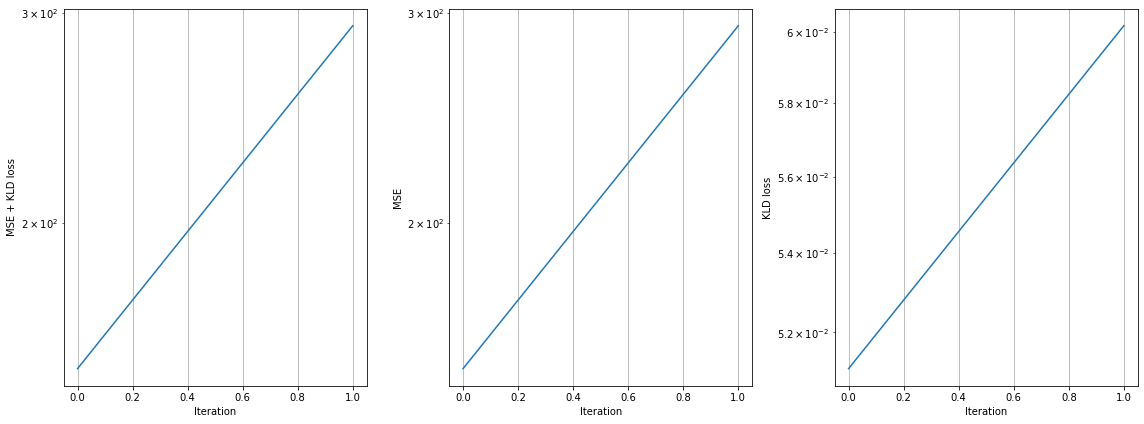

loss: 292.69964599609375, loss(avg): 221.79978942871094:   0%|          | 2/500 [01:03<4:27:31, 32.23s/it]

KeyboardInterrupt: ignored

In [10]:
train_cvae(model,
           train_dataloader,
           optimizer,
           device,
           cfg,
           plot_mode=True)

# Extractor training:

In [10]:
from models import CVAE, TrajectoriesExtractor
from train.train_extractor import train_extractor

In [16]:
del train_extractor
import gc
gc.collect()

23037

In [ ]:
CVAE_WEIGHTS_PATH = f'{MODEL_PATH}/CVAE_{4200}_{35}'

cvae_model = CVAE(cfg).to(device)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device(device))
cvae_model.load_state_dict(checkpoint['model_state_dict'])
cvae_model.eval()

In [11]:
cvae_model = model

In [12]:
# Initialize model and optimizer
extractor_model = TrajectoriesExtractor(cfg).to(device)
optimizer = optim.Adam(extractor_model.parameters(), cfg['train_extractor_params']['lr'])

In [13]:
confs = torch.Tensor([0.7, 0.2, 0.1]).expand(train_cfg['batch_size'], 3).to(device)

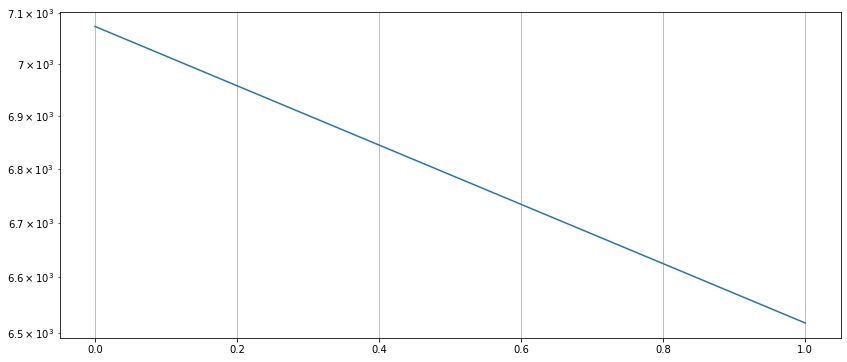

loss: 6517.49560546875, loss(avg): 6795.52783203125:   1%|          | 2/200 [30:10<49:49:31, 905.91s/it]

KeyboardInterrupt: ignored

In [14]:
train_extractor(cvae_model,
                extractor_model,
                train_dataloader,
                confs,
                optimizer,
                device,
                cfg,
                plot_mode=True)